<a href="https://colab.research.google.com/github/ChristianVo55/MachineLearning/blob/main/fcc_bikes_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imblearn.over_sampling as RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

In [15]:
dataset_cols = ["Rented Bike count", "Hour", "Temperature", "Humidity", "Windspeed", "Visibilty", "Dew point temperature", "Solar radiation", "Rainfall", "Snowfall", "Functional Day"]
df = pd.read_csv("SeoulBikeData.csv", encoding='latin-1').drop(["Date", "Holiday", "Seasons"], axis = 1)
df.columns = dataset_cols
df["Functional Day"] = (df["Functional Day"] == "Yes").astype(int)
df = df[df["Hour"] == 12]
df = df.drop(["Hour"], axis = 1)
df.head()

,Rented Bike count,Temperature,Humidity,Windspeed,Visibilty,Dew point temperature,Solar radiation,Rainfall,Snowfall,Functional Day
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


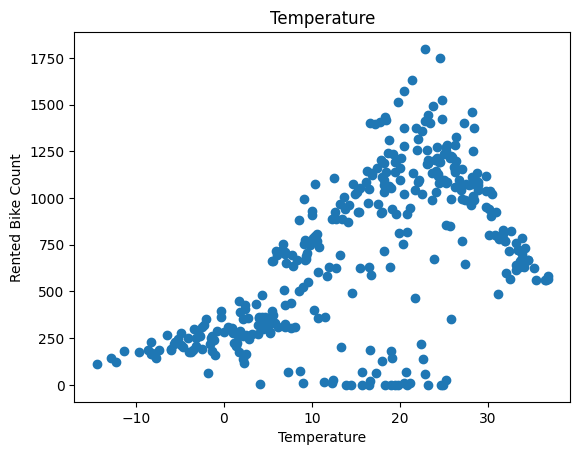

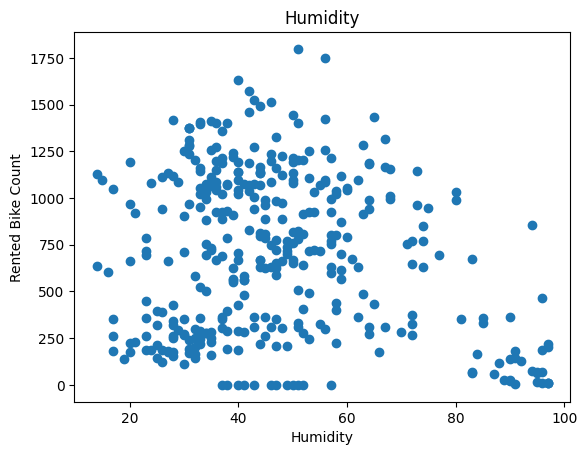

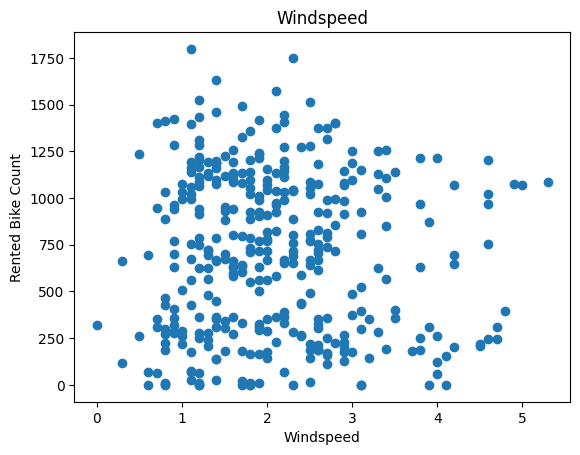

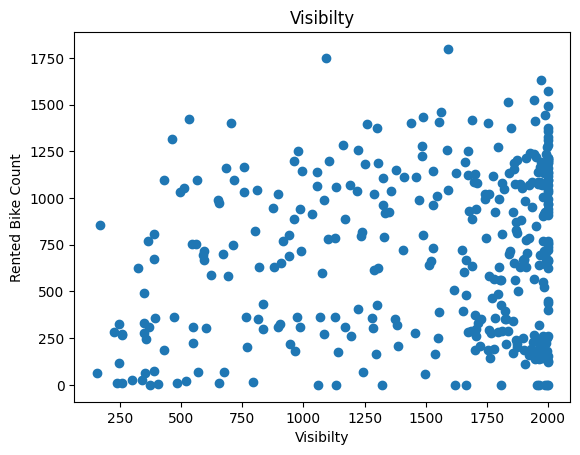

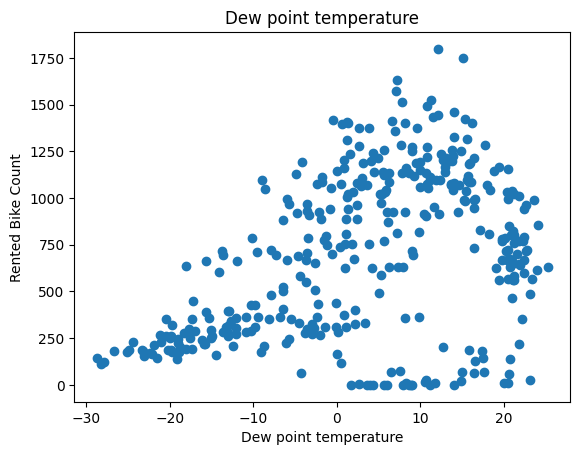

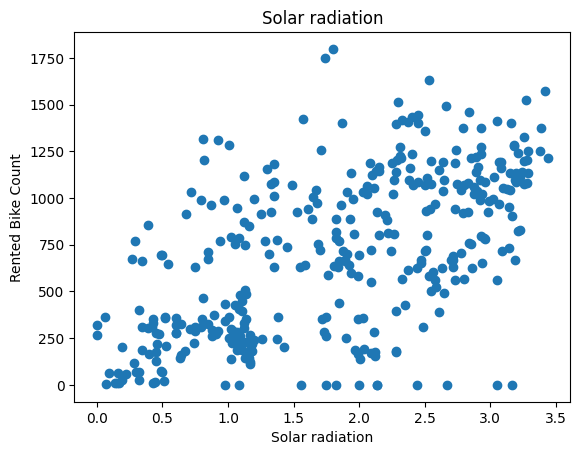

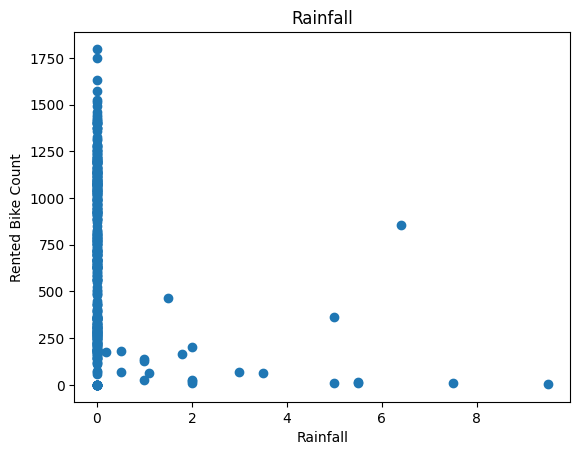

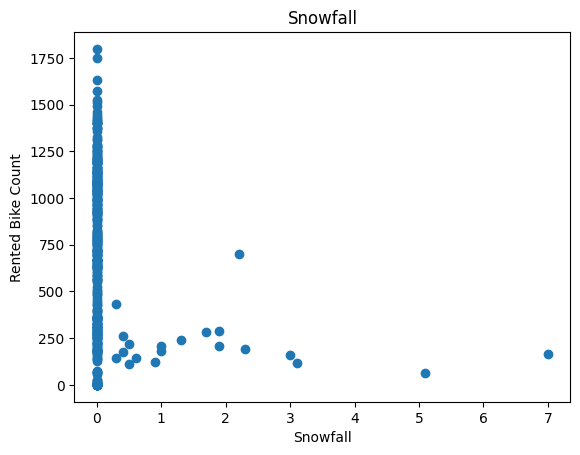

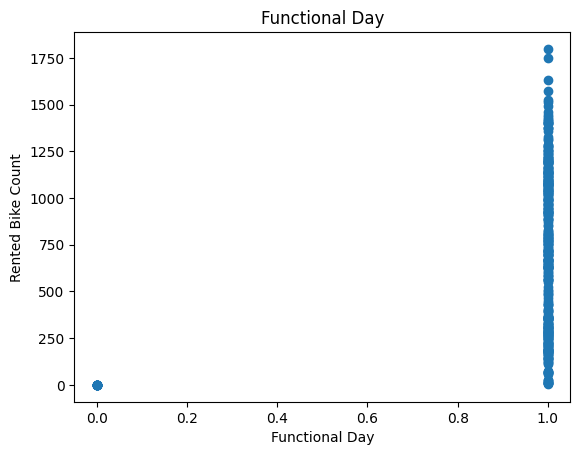

In [17]:
for label in df.columns[1:]:
    plt.scatter(df[label], df["Rented Bike count"])
    plt.title(label)
    plt.ylabel("Rented Bike Count")
    plt.xlabel(label)
    plt.show()

In [19]:
df = df.drop(["Windspeed", "Visibilty", "Functional Day"], axis = 1)

# Tain/valid/test dataset

In [21]:
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

In [83]:
def get_xy(dataframe, y_label, x_labels = None):
    dataframe = copy.deepcopy(dataframe)
    if x_labels is None:
        X = dataframe[[c for c in dataframe.columns if c != y_label]].values
    else:
      if len(x_labels) == 1:
        X = dataframe[x_labels[0]].values.reshape(-1, 1)
      else:
        X = dataframe[x_labels].values

    y = dataframe[y_label].values.reshape(-1, 1)
    data = np.hstack((X,y))

    return data, X, y

In [84]:
_, X_train_temp, y_train_temp = get_xy(train, "Rented Bike count", x_labels=["Temperature"])
_, X_valid_temp, y_valid_temp = get_xy(valid, "Rented Bike count", x_labels=["Temperature"])
_, X_test_temp, y_test_temp = get_xy(test, "Rented Bike count", x_labels=["Temperature"])

In [28]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

LinearRegression()

In [31]:
temp_reg.score(X_test_temp, y_test_temp)

0.38039746120328843

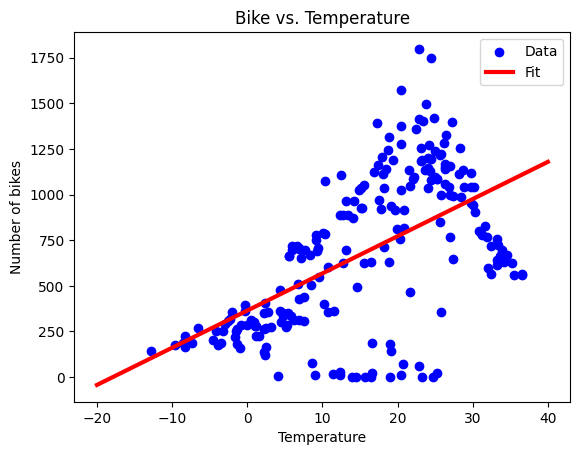

In [38]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1,1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bike vs. Temperature")
plt.ylabel("Number of bikes")
plt.xlabel("Temperature")
plt.show()

# Multiple Linear Regression

In [44]:
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
_, X_train_all, y_train_all = get_xy(train, "Rented Bike count", x_labels=df.columns[1:])
_, X_valid_all, y_valid_all = get_xy(valid, "Rented Bike count", x_labels=df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, "Rented Bike count", x_labels=df.columns[1:])

In [45]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)

LinearRegression()

In [46]:
all_reg.score(X_test_all, y_test_all)

0.5006266704908708

# Regression with Neural Net

In [53]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

In [87]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

In [88]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [92]:
temp_nn_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_squared_error'
)

In [93]:
history = temp_nn_model.fit(
    X_train_temp.reshape(-1), y_train_temp,
    epochs=1000,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_data = (X_valid_temp, y_valid_temp)
)

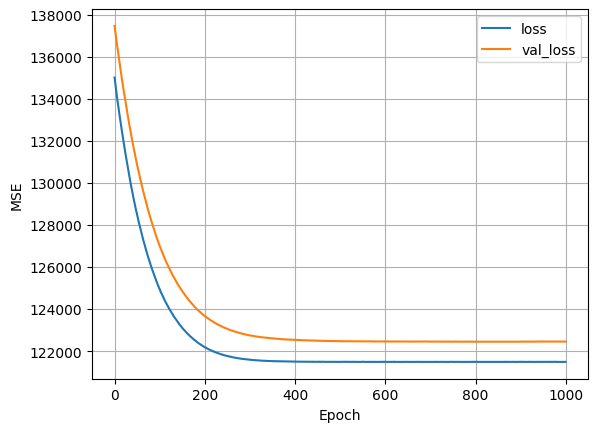

In [94]:
plot_loss(history)

4/4 [==============================] - 0s 4ms/step


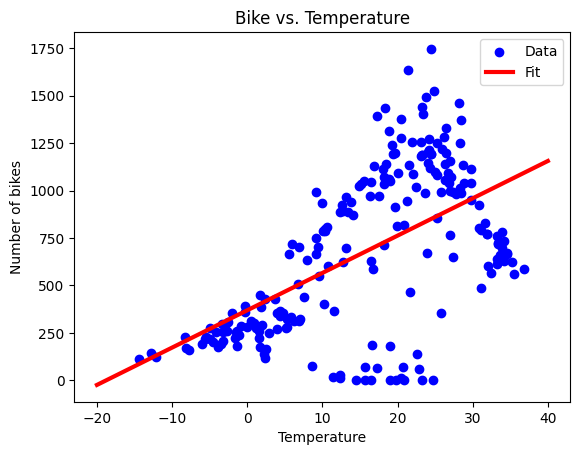

In [95]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1,1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bike vs. Temperature")
plt.ylabel("Number of bikes")
plt.xlabel("Temperature")
plt.show()

# Neural Net

In [104]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
nn_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error'
)

In [105]:
history = nn_model.fit(
    X_train_temp, y_train_temp,
    validation_data = (X_valid_temp, y_valid_temp),
    epochs=100,
    verbose = 0
)

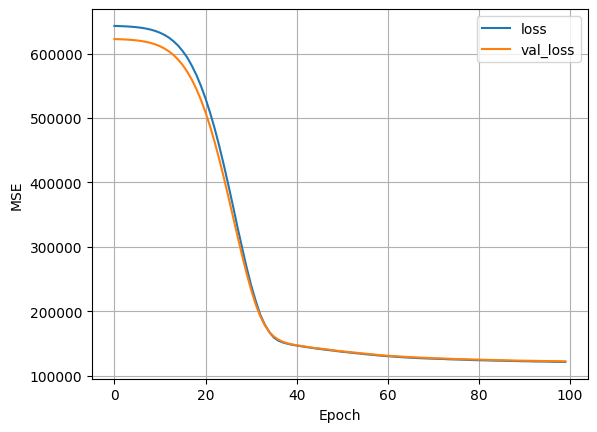

In [106]:
plot_loss(history)

4/4 [==============================] - 0s 3ms/step


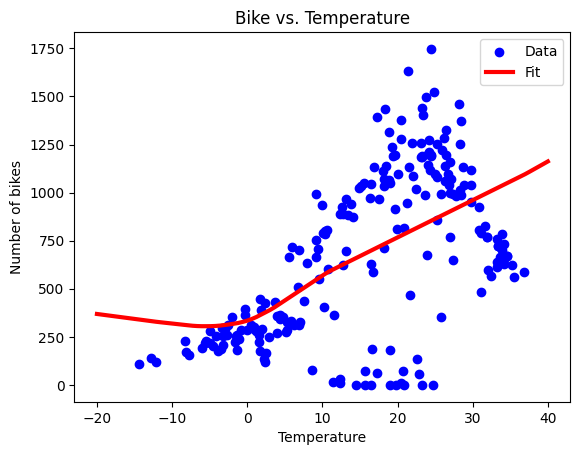

In [107]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1,1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bike vs. Temperature")
plt.ylabel("Number of bikes")
plt.xlabel("Temperature")
plt.show()

In [118]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=-1)
all_normalizer.adapt(X_train_all)


In [119]:
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
nn_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error'
)

In [120]:
history = nn_model.fit(
    X_train_all, y_train_all,
    validation_data = (X_valid_all, y_valid_all),
    epochs=100,
    verbose = 0
)

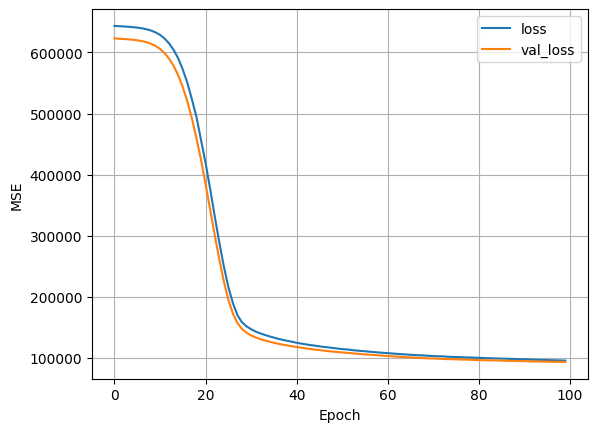

In [121]:
plot_loss(history)

In [122]:
# calculate the MSE for both linear reg and nn
y_pred_lr = all_reg.predict(X_test_all)
y_pred_nn = nn_model.predict(X_test_all)

3/3 [==============================] - 0s 4ms/step


In [115]:
def MSE(y_pred, y_real):
  return (np.square(y_pred - y_real)).mean()

In [116]:
MSE(y_pred_lr, y_test_all)

101247.02571266615

In [123]:
MSE(y_pred_nn, y_test_all)

105709.52717697171

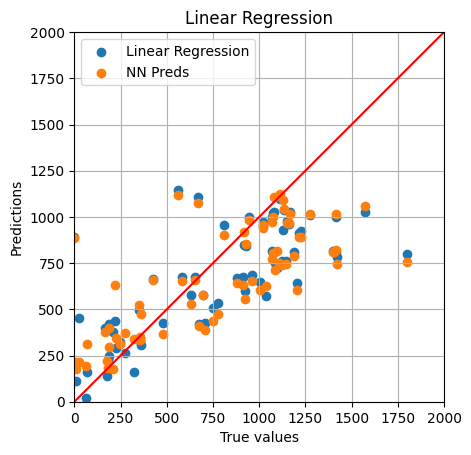

In [126]:
ax = plt.axes(aspect="equal")
plt.scatter(y_test_all, y_pred_lr, label = "Linear Regression")
plt.scatter(y_test_all, y_pred_nn, label = "NN Preds")
plt.xlabel("True values")
plt.ylabel("Predictions")
plt.title("Linear Regression")
plt.legend()
lims = [0, 2000]
plt.xlim(lims)
plt.ylim(lims)
plt.grid(True)
_ = plt.plot(lims, lims, c="red")